# 백테스팅 시뮬레이션

백테스트란 현재 생각하는 전략을 과거부터 실행했을 때 어떠한 성과가 발생하는지 테스트해보는 과정이다. 과거의 데이터를 기반으로 전략을 실행하는 퀀트 투자에 있어서 이는 핵심 단계다. 백테스트 결과를 통해 해당 전략의 손익뿐만 아니라 각종 위험을 대략적으로 판단할 수 있으며, 어떤 구간에서 전략이 좋았는지 혹은 나빴는지에 대한 이해도 키울 수 있다. 이러한 이해를 바탕으로 퀀트 투자를 지속한다면 단기적으로 수익이 나쁜 구간에서도 그 이유에 대한 객관적인 안목을 키울 수 있으며, 확신을 가지고 전략을 지속할 수 있다.

그러나 백테스트를 아무리 보수적으로 혹은 엄밀하게 진행하더라도 이미 일어난 결과를 대상으로 한다는 사실은 변하지 않는다. 백테스트 수익률만을 보고 투자에 대해 판단하거나, 혹은 동일한 수익률이 미래에도 반복될 것이라고 믿는다면 이는 백미러만 보고 운전하는 것처럼 매우 위험한 결과를 초래할 수도 있다.

파이썬에는 백테스트를 위한 수많은 패키지들이 존재하며 대표적인 패키지는 다음과 같다.

- backtesting: 각종 트레이딩 전략에 최적화된 인터페이스를 제공하며, 앞서 살펴본 TA-Lib 패키지와의 상당한 호환성 및 파라미터에 대한 최적화 기능도 제공한다. 
```
https://kernc.github.io/backtesting.py/
```

- Backtrader: 구글에서 파이썬 관련 백테스트를 검색하면 가장 많이 검색되는 패키지일 만큼 사용법에 대한 메뉴얼이 잘 구성되어 있다. 
```
https://www.backtrader.com/
```

- bt: 앞의 패키지들과는 다르게 트레이딩 전략 뿐만 아니라 포트폴리오 기반의 퀀트를 백테스트를 하는데도 매우 유용한 기능들을 제공한다.
```
https://pmorissette.github.io/bt/
```

모든 패키지에는 장단점이 있기 마련이기에, 모두 사용해보고 본인에게 맞는것을 선택하는 것이 최고의 방법이다. 본 책에서는 포트폴리오 전략과 트레이딩 전략을 동시에 다루기에 bt 패키지를 사용해 백테스트를 하도록 하겠다. 해당 패키지에는 본 책에서 다루는 내용 외에도 백테스트 및 결과 평가에 대한 수많은 함수들이 존재하기에, 공식 페이지와 github의 코드를 모두 살펴보는 것도 재밌는 작업이다.

또한 bt 패키지의 함수는 대부분 ffn 패키지를 기초로 만들어져 있으므로 이 역시 찾아보는 것을 추천한다.

```
http://pmorissette.github.io/ffn/
```

## bt 패키지 

bt 패키지에서는 백테스트의 과정을 다음과 같이 정의한다.

1. 데이터의 수집
2. 전략의 정의
3. 데이터를 이용한 전략의 백테스트
4. 결과에 대한 평가

### 데이터의 수집

백테스트를 위해서는 먼저 데이터를 준비해야 한다. bt 패키지의 `get()` 함수는 야후 파이낸스 API를 이용해 수정주가를 다운로드 받을 수 있게 해준다. 물론 기존의 Pandas-datareader 패키지나 크롤링을 통해 데이터를 수집할 수도 있다. 

In [1]:
import bt

data = bt.get("SPY, TLT", start='2003-01-01', end='2021-12-31')
data.head()

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,spy,tlt
Date,,
2003-01-02,60.733505,42.280861
2003-01-03,60.920269,42.378864
2003-01-06,61.993938,42.266159
2003-01-07,61.840565,42.418087
2003-01-08,60.946922,42.628769


`get()` 함수 내에 다운로드 받고자 하는 종목의 티커를 입력하면 수정주가만 데이터프레임 형태로 가공된다. 우리는 이미 받은 글로벌 자산을 대표하는 ETF 데이터를 DB에 저장했기에 이를 불러와 사용하겠다.

In [3]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('mysql+pymysql://root:@127.0.0.1:3306/stock_db')
with engine.connect() as connection:
    price = pd.read_sql('select * from sample_etf;', con=engine)
    price = price.set_index(['Date'])
engine.dispose()

price.tail()

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
Date,,,,,,,,,,
2024-06-25,544.830017,55.430000,67.559998,42.570000,94.200378,94.222389,86.589996,24.190001,214.559998,23.170000
2024-06-26,545.510010,54.939999,67.309998,42.480000,92.854660,93.654121,86.339996,23.940001,212.580002,23.209999
2024-06-27,546.369995,54.849998,67.650002,42.509998,93.223480,93.863480,87.070000,23.950001,214.990005,23.330000
2024-06-28,544.219971,54.759998,68.239998,42.590000,91.488998,93.365005,87.739998,24.000000,215.009995,23.230000
2024-07-01,545.340027,55.040001,67.790001,42.689999,89.910004,92.669998,86.930000,23.879999,215.570007,23.530001


### 전략의 정의

두번째로 시뮬레이션 하고자 하는 백테스트가 어떤 것인지를 정의해야 한다. 10개 자산을 동일비중으로 투자하며, 매월 말 리밸런싱 하는 전략을 정의해보도록 하겠다. `Strategy()` 함수 내에 algos 모듈을 이용해 백테스트 하고자 하는 내용을 입력한다.

In [9]:
import bt

# 전체 자산 동일비중, 매월 말 리밸런싱
strategy = bt.Strategy("Asset_EW", [
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])

1. 먼저 전략의 이름(Asset_EW)을 입력한다.
2. `bt.algos.SelectAll()` 함수를 통해 모든 데이터를 사용함을 정의한다.
3. `bt.algos.WeighEqually()` 함수를 통해 동일비중으로 투자할 것을 정의한다.
4. `bt.algos.RunMonthly()` 함수를 통해 매월말 리밸런싱 함을 정의한다.
5. `bt.algos.Rebalance()` 함수를 통해 계산된 비중에 따라 리밸런싱 함을 정의한다.

이 외에 algos 모듈을 통해 다양한 백테스트 로직을 정의할 수 있으며, 자세한 내용은 아래 사이트에서 확인할 수 있다.

```
https://pmorissette.github.io/bt/bt.html#module-bt.algos
```

### 전략의 백테스트

앞에서 정의된 내용을 바탕으로 백테스트를 실행한다.

In [5]:
data = price.dropna()

# 백테스트 생성
backtest = bt.Backtest(strategy, data)

# 백테스트 실행
result = bt.run(backtest)

1. 가격 데이터 중 ETF의 시작 시점이 모두 다르므로, `dropna()` 함수를 통해 NA를 모두 제거하여 시작시점을 동일하게 만든다.
2. `Backtest()` 함수를 통해 백테스트를 생성할 수 있으며, 앞에서 정의한 백테스트 정의(strategy)와 가격 데이터(data)를 입력한다.
3. `run()` 함수를 통해 백테스트를 실행하며, 앞에서 생성된 백테스트(backtest)를 입력한다.

### 결과에 대한 평가

위에서 시뮬레이션 된 백테스트의 결과를 살펴보도록 하자.

In [6]:
result.prices

,Asset_EW
2006-12-18,100.000000
2006-12-19,100.000000
2006-12-20,100.208572
2006-12-21,100.077624
2006-12-22,100.038753
...,...
2024-06-25,224.463159
2024-06-26,223.248656
2024-06-27,224.081137
2024-06-28,223.766980


백테스트 결과에서 `prices`를 입력하면 누적수익률이 데이터프레임 형태로 나타나며, 시작시점을 100으로 환산하여 계산된다.

In [7]:
result.prices.to_returns()

,Asset_EW
2006-12-18,NaN
2006-12-19,-1.110223e-16
2006-12-20,2.085722e-03
2006-12-21,-1.306755e-03
2006-12-22,-3.884052e-04
...,...
2024-06-25,-8.894570e-04
2024-06-26,-5.410701e-03
2024-06-27,3.728938e-03
2024-06-28,-1.401976e-03


`prices`에 추가로 `to_returns()`를 입력하면, 수익률이 계산된다.

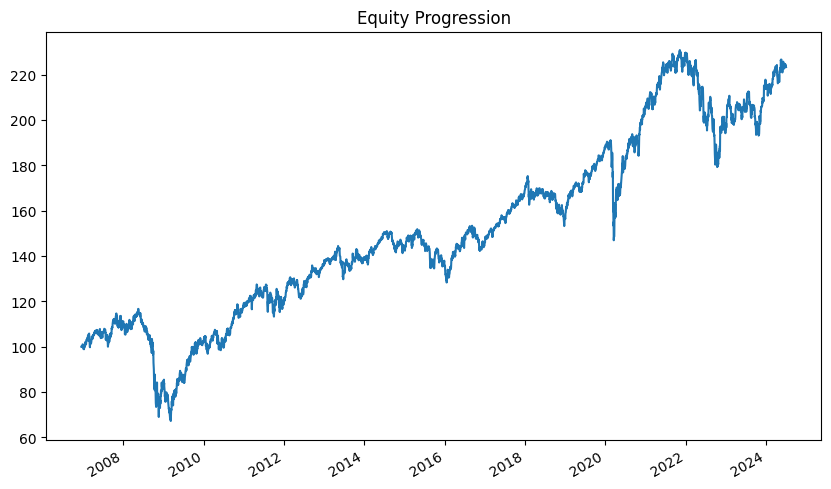

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

result.plot(figsize=(10, 6), legend=False)
plt.show()

`plot()` 메서드를 통해 누적수익률을 그래프로 나타낼 수 있다.

In [9]:
result.get_security_weights().head()

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
2006-12-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-12-19,0.099986,0.099974,0.099966,0.099995,0.099998,0.099971,0.099969,0.099975,0.099992,0.099978
2006-12-20,0.099722,0.099186,0.100469,0.100891,0.099779,0.099739,0.100590,0.099965,0.099494,0.099972
2006-12-21,0.099487,0.099367,0.101175,0.100842,0.100411,0.100230,0.099754,0.100211,0.099236,0.099094
2006-12-22,0.098914,0.098765,0.101574,0.101243,0.099681,0.099812,0.099017,0.101189,0.099711,0.099899


`get_security_weights()` 메서드를 통해 각 종목 별 투자 비중을 확인할 수도 있다. 이를 그림으로 나타내보도록 하자.

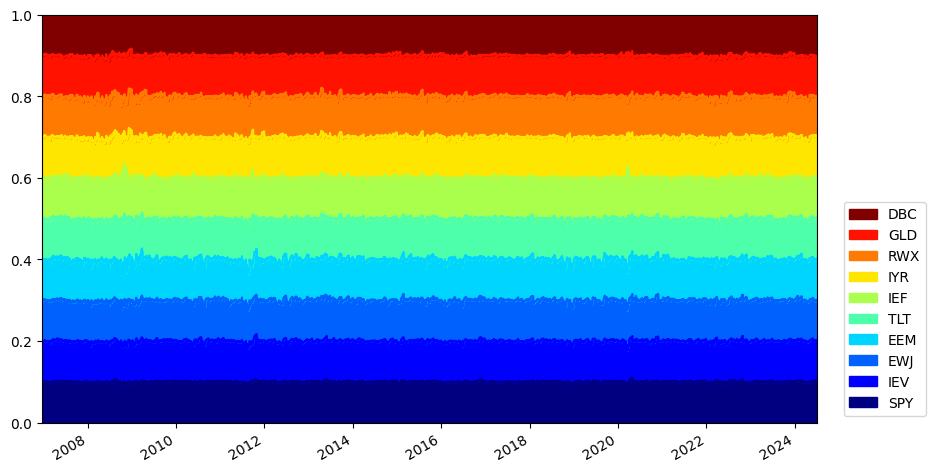

In [10]:
from matplotlib import cm

ax = result.get_security_weights().plot.area(figsize=(10, 6),
                                             ylim=[0, 1],
                                             legend=False,
                                             colormap=cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles),
           reversed(labels),
           loc='lower right',
           bbox_to_anchor=(1.15, 0))
plt.show()

1. `area()`를 통해 면적 그래프를 나타내며, $y$축의 범위는 0에서 1, 범례(legend)는 제외, 색 구분은 cm.jet을 이용한다.
2. `get_legend_handles_labels()`를 통해 범례를 받아온다.
3. 좌우 마진을 0으로 둔다.
4. `legend()` 함수를 통해 범례를 나타내며, 그래프와 색 순서를 맞추기 위해 `reversed()`를 통해 순서를 바꾼다. 또한 위치는 오른쪽 아래(lower right)의 (1.15, 0) 지점으로 한다.
5. 그림을 나타낸다.

매월 말 리밸런싱을 하므로, 대부분의 구간에서 모든 자산에 10%씩 균등하게 투자된다. 이번에는 각종 성과지표를 확인해보도록 하자.

In [11]:
result.display()

Stat                 Asset_EW
-------------------  ----------
Start                2006-12-18
End                  2024-07-01
Risk-free rate       0.00%

Total Return         123.31%
Daily Sharpe         0.41
Daily Sortino        0.64
CAGR                 4.69%
Max Drawdown         -42.35%
Calmar Ratio         0.11

MTD                  -0.20%
3m                   0.42%
6m                   2.95%
YTD                  2.95%
1Y                   8.35%
3Y (ann.)            0.21%
5Y (ann.)            4.88%
10Y (ann.)           4.02%
Since Incep. (ann.)  4.69%

Daily Sharpe         0.41
Daily Sortino        0.64
Daily Mean (ann.)    5.50%
Daily Vol (ann.)     13.48%
Daily Skew           -0.21
Daily Kurt           10.32
Best Day             7.81%
Worst Day            -6.77%

Monthly Sharpe       0.44
Monthly Sortino      0.70
Monthly Mean (ann.)  5.25%
Monthly Vol (ann.)   12.04%
Monthly Skew         -0.83
Monthly Kurt         3.66
Best Month           8.67%
Worst Month          -17.98%

Yea

`display()` 메서드를 통해 각종 성과 측정치를 구할 수 있다. 각 지표가 의미하는 바는 다음과 같다.

- Start; 시작일
- End: 종료일
- Risk-free rate: 무위험 수익률
- Total Return: 총 수익률
- Sharpe: 샤프지수 (평균 수익률/변동성)
- Sortino: 소티노지수 (평균 수익률/마이너스 수익률의 변동성)
- CAGR: 연평균 수익률
- Max drawdown: 최대 손실률 (MDD)
- Calmar Ratio: 칼마지수 (수익률/MDD)
- MTD / 3m / 6m / YTD: 금월, 3개월, 6개월, 올해 수익률
- 1Y / 3Y (ann.) / 5Y (ann.) / 10Y (ann.): 1년 / 3년 / 5년 / 10년 기준 연율화 수익률
- Since Incep. (ann): 시작 이후 연율화 수익률
- Mean (ann.): 연평균 수익률
- Vol (ann.): 연평균 변동성
- Skew: 왜도
- Kurt: 첨도
- Best: 최고 수익률
- Worst: 최저 수익률
- Avg. Drawdown: 손실(Drawdown)의 평균
- Avg. Drawdown Days: 손실(Drawdown) 발생 후 회복까지 평균일수
- Avg. Up Month: 상승한 달의 평균 수익률
- Avg. Down Month: 하락한 달의 평균 수익률
- Win Year %: 연도별 양의 수익률을 기록할 확률
- Win 12m %: 12개월 투자했을 시 양의 수익률을 기록할 확률

## 정적 자산배분: 올웨더 포트폴리오

자산배분은 포트폴리오 내에 다양한 자산에 분산 투자하여 위험을 줄이고 일정수준의 수익률 달성하고자 하는 방법이다. 이러한 자산 배분은 크게 '정적 자산배분'과 '동적 자산배분'으로 나뉜다.

정적 자산배분은 주식과 채권 등 자산에 대한 비중을 어떠한 시장 상황에서도 6:4 혹은 8:2로 배분하고 유지하는 전략이다. 대표적인 정적 자산배분 전략은 레이 달리오가 운용하는 기법으로 유명해진 올웨더 포트폴리오가 있다. 레이 달리오는 세계 최대 헤지펀드인 브릿지워터(Bridgewater Associate)의 설립자이다. 그는 시시각각 변화는 경제 상황속에서 어떻게 자산배분을 해도 견딜수 있는 포트폴리오를 구상하였으며, 이것이 올웨더 포트폴리오다. 경제환경은 크게 경제 성장률과 물가 상승률로 나눌 수 있으며, 각 국면마다 우수한 성과를 보이는 자산은 다르다.

```{figure} image/backtest/allweather.png
---
name: allweather
---
경제환경의 구분
```

1. 경제 성장률이 높은 구간에서는 위험 자산의 성과가 우수하다.
2. 경제 성장률이 낮은 구간에서는 채권의 성과가 우수하다. 
3. 물가 상승률이 높은 구간에서는 원자재나 신흥국 채권의 성과가 우수다. 
4. 물가 상승률이 낮은 구간에서는 주식과 채권의 성과가 우수하다.

올웨더 포트폴리오는 네 가지 상황 중 하나를 예측하기 보다는, 각각의 상황에 맞는 자산을 모두 포트폴리오에 담아 미리 대비한다. 또한 각 상황이 올 확률이 25%씩 같다고 가정할 경우, 자산별 투자비중은 {numref}`aw`와 같다.

```{figure} image/backtest/aw.png
---
name: aw
---
올웨더 포트폴리오 투자 비중
```

올웨더 포트폴리오의 투자 비중을 이용해 백테스트를 해보도록 하겠다.

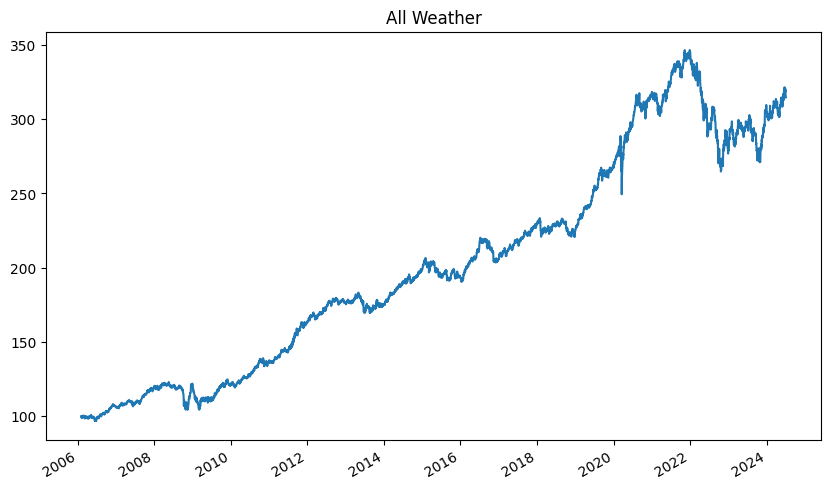

In [12]:
import bt
import matplotlib.pyplot as plt
%matplotlib inline

data = price[['SPY', 'TLT', 'IEF', 'GLD', 'DBC']].dropna()

aw = bt.Strategy('All Weather', [
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(SPY=0.3, TLT=0.4, IEF=0.15, GLD=0.075, DBC=0.075),
    bt.algos.RunQuarterly(),
    bt.algos.Rebalance()
])
aw_backtest = bt.Backtest(aw, data)
aw_result = bt.run(aw_backtest)

aw_result.plot(figsize=(10, 6), title='All Weather', legend=False)
plt.show()

1. price 데이터 중 주식(SPY), 장기채(TLT), 중기채(IEF), 금(GLD), 원자재(DBC)에 해당하는 데이터만 선택한다.
2. 전략을 정의해주며, `bt.algos.WeighSpecified()`에 각 자산별 비중을 직접 입력한다. 또한 `bt.algos.RunQuarterly()`를 통해 분기별 리밸런싱을 정의한다.
3. 백테스트를 생성 및 실행한다.

이번에는 비중을 살펴보자.

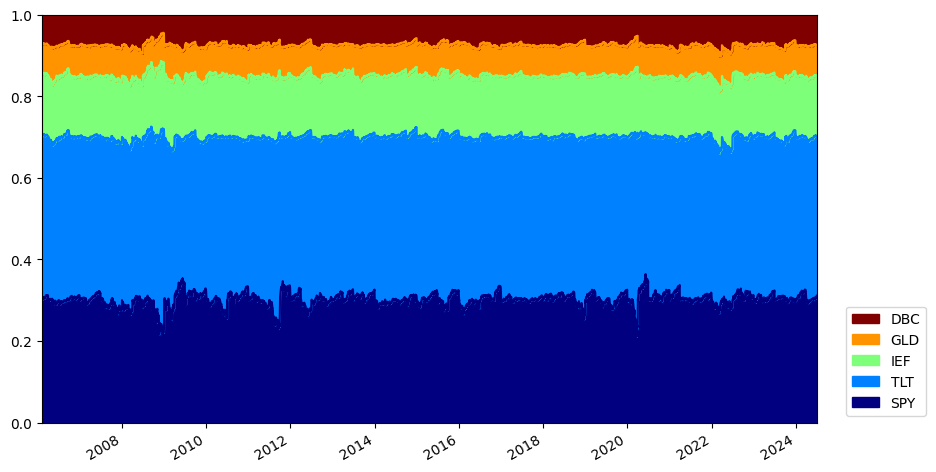

In [13]:
from matplotlib import cm

ax = aw_result.get_security_weights().plot.area(figsize=(10, 6),
                                                ylim=[0, 1],
                                                legend=False,
                                                colormap=cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles),
           reversed(labels),
           loc='lower right',
           bbox_to_anchor=(1.15, 0))
plt.show()

분기 별로 리밸런싱이 이루어짐에 따라, 각 자산별 투자비중이 일정하게 유지된다. 마지막으로 성과 중 주요 지표를 확인해보자.

In [14]:
aw_result.stats.loc[[
    'total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe'
]]

,All Weather
total_return,2.146263
cagr,0.064272
daily_vol,0.081169
max_drawdown,-0.236024
calmar,0.272309
daily_sharpe,0.809119


수많은 성과지표 중 중요한 지표만 선택하여 확인할 수 있다.

## 동적 자산배분

정적 자산배분이 자산 별 일정 비중을 유지하는 전략이라면, 동적 자산배분은 시장 상황에 따라 투자하는 대상과 비중을 계속해서 변경하는 전략이다. 여러 경제 상황에서 상대적으로 유리한 자산은 좋은 성과를 보일 것이며, 경제 국면은 장기간 지속되는 추세가 있으므로 모멘텀이 있는 자산에 투자하는 것이 현명한 방법일 수 있다. 모멘텀을 이용한 동적 자산배분 포트폴리오의 예시는 다음과 같다.

1. 글로벌 10개 자산 중 과거 12개월 수익률이 높은 5개 자산을 선택한다.
2. 위험균형 포트폴리오를 구성한다.
3. 매월 말 리밸런싱을 실시한다.

10개 자산에서 과거 수익률 기준 5개 자산만 선택하는 이유는 모멘텀 효과를 얻기 위해서다. {numref}`mom_rank`는 글로벌 10개 자산의 과거 6개월 수익률을 기준으로 순위를 매기고, 각 순위 별로 다음 월의 수익률이 상위 50%가 될 확률을 구한 값이다. 수익률이 높은 1~5위 까지의 자산은 다음 월에도 수익률이 높을 확률이 50%가 넘지만, 수익률이 낮은 6~10위 까지의 자산은 다음 월에 수익률이 높을 확률이 50%가 되지 않는다. 따라서 자산군 간에도 모멘텀 효과가 존재하며, 이를 활용하기 위해 모멘텀 상위 자산만을 선택해 투자한다.

```{figure} image/backtest/mom_rank.png
---
name: mom_rank
---
자산군 내 모멘텀 효과
```

또한 위험균형 포트폴리오를 이용해 변동성이 지나치게 큰 자산에 의해 포트폴리오의 수익률이 크게 영향받는 일을 줄이고, 최대한 안정적인 포트폴리오를 구성한다. 동적 자산배분의 로직이 다소 복잡해 보이지만, bt 패키지에 내장된 함수를 이용할 경우 역시나 매우 손쉽게 백테스트 할 수 있다.

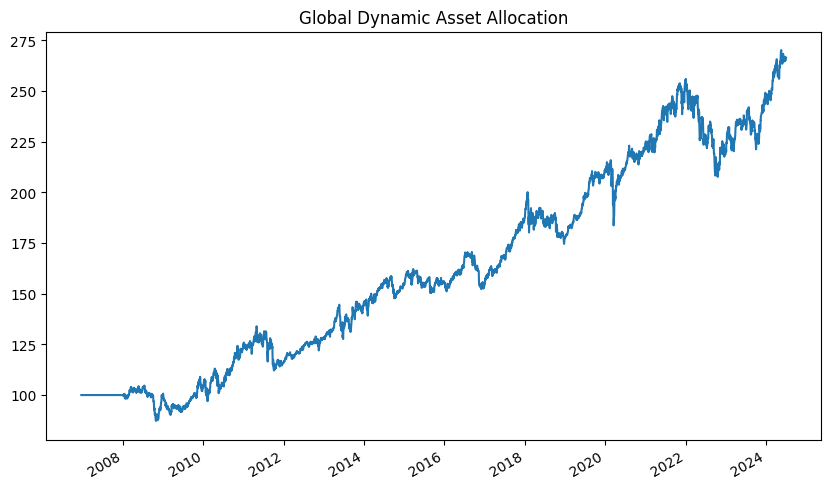

In [15]:
import bt
import matplotlib.pyplot as plt

data = price.dropna()

gdaa = bt.Strategy('GDAA', [
    bt.algos.SelectAll(),
    bt.algos.SelectMomentum(n=5, lookback=pd.DateOffset(years=1)),
    bt.algos.WeighERC(lookback=pd.DateOffset(years=1)),
    bt.algos.RunMonthly(),    
    bt.algos.Rebalance()
])

gdaa_backtest = bt.Backtest(gdaa, data)
gdaa_result = bt.run(gdaa_backtest)

gdaa_result.plot(figsize=(10, 6),
                 title='Global Dynamic Asset Allocation',
                 legend=False)
plt.show()

1. `bt.Strategy()` 내에 전략을 정의해준다.
    - `bt.algos.SelectAll()`: 전체 데이터를 선택한다.
    - `bt.algos.SelectMomentum(n=5, lookback=pd.DateOffset(years=1))`: 모멘텀 상위 종목을 선택하며 갯수는 5개, 모멘텀 관측 기간은 과거 1년으로 한다.
    - `bt.algos.WeighERC(lookback = pd.DateOffset(years=1))`: ERC 즉 위험균형 포트폴리오를 구성하며, 분산-공분산 계산을 위한 수익률은 과거 1년 데이터를 이용한다.
    - `bt.algos.RunMonthly()`: 매월 리밸런싱을 실시한다.    
    - `bt.algos.Rebalance()`: 리밸런싱을 정의한다.
2. 백테스트를 생성 및 실행한다.

이처럼 algos 모듈 내의 각종 함수를 이용하면 다양한 전략을 손쉽게 정의 및 백테스트 할 수 있다.

```{note}
그래프를 살펴보면 처음 1년간은 수익률에 변화가 없으며, 이는 모멘텀 관측을 위한 1년 간은 투자를 할 수 없기 때문이다. 성과를 평가할 때는 이처럼 투자가 이루어지지 않는 기간을 제외하고 실제 투자가 이루어진 부분부터 평가해야 한다.
```

### 거래 비용 고려하기

정적 자산배분과는 달리 동적 자산배분은 매 시점마다 투자하는 대상 및 투자비중이 변한다. 비중을 확인해보도록 하자.

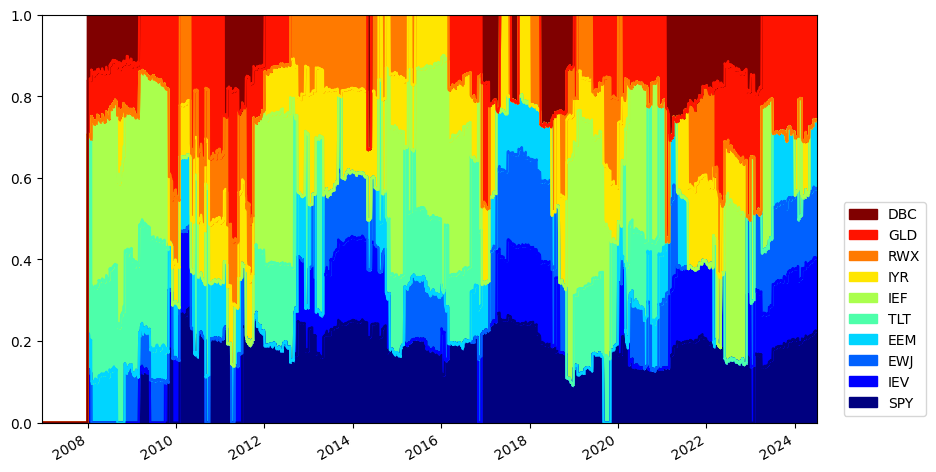

In [16]:
from matplotlib import cm

wt = gdaa_result.get_security_weights().reindex(columns=price.columns)
ax = wt.plot.area(figsize=(10, 6), ylim=[0, 1], legend=False, colormap=cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles),
           reversed(labels),
           loc='lower right',
           bbox_to_anchor=(1.15, 0))
plt.show()

기존 정적 자산배분보다 투자 비중의 변화가 상당히 심한것을 확인할 수 있다. 이는 수익률 상위 5개에 해당하는 자산이 매월 말 바뀌며, 위험균형 포트폴리오를 구성하는 비중이 계속해서 바뀌기 때문이다. 모델 포트폴리오의 경우 이러한 점을 신경쓰지 않지만, 실제 투자에서는 잦은 턴오버로 인한 매매비용, 세금, 기타비용 등이 매우 중요해진다. 해당 전략의 턴오버를 살펴보도록 하자.

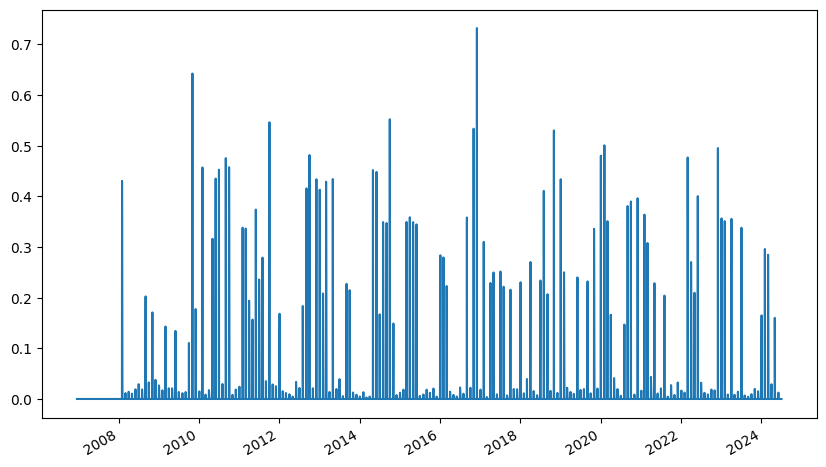

In [17]:
gdaa_backtest.turnover.plot(figsize=(10, 6), legend=False)
plt.show()

생성된 백테스트에서 `turnover` 메서드를 통해 턴오버를 구할 수 있다. 매월 상당한 턴오버가 발생하므로, 이를 고려한 수익률을 추가로 살펴볼 필요가 있다. 매수 혹은 매도당 발생하는 세금, 수수료, 시장충격 등 총 비용을 0.2%로 가정하여 백테스트를 실행한다.

In [18]:
gdaa_backtest_net = bt.Backtest(gdaa,
                                data,
                                name='GDAA_net',
                                commissions=lambda q, p: abs(q) * p * 0.002)
gdaa_result = bt.run(gdaa_backtest, gdaa_backtest_net)

1. `bt.Backtest()` 함수 내에 기존에 정의된 백테스트인 gdaa를 그대로 사용하며, commissions 부분에 수수료를 계산하는 부분을 입력한다. q는 quantity(주수), p는 price(주가)를 의미하며, 즉 총 거래 가격에서 0.2%가 수수료로 나간다고 가정한다.
2. `bt.run()` 내에 기존에 생성된 백테스트 내용(gdaa_backtest)과 새롭게 생성된 백테스트 내용(gdaa_backtest_net)을 동시에 입력하면, 두 개의 백테스트가 한번에 실행된다.

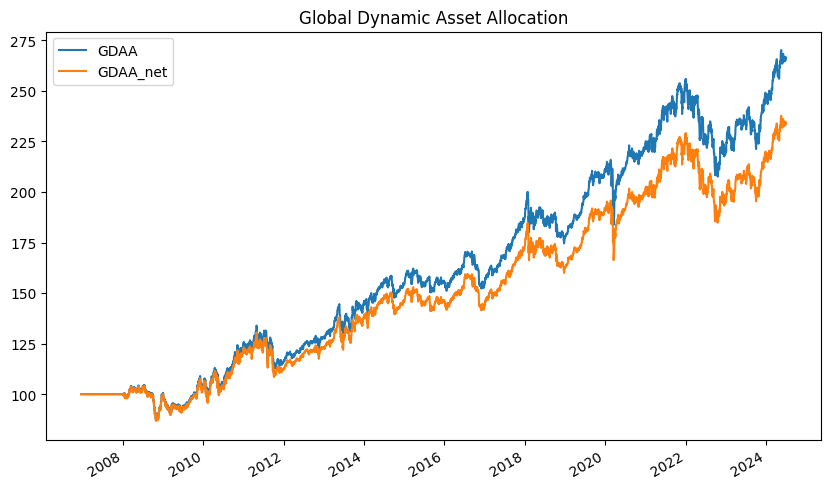

In [19]:
gdaa_result.prices.plot(figsize=(10, 6),
                        title='Global Dynamic Asset Allocation')
plt.show()

기존의 비용을 고려하지 않은 포트폴리오(GDAA)에 비해, 비용을 차감한 포트폴리오(GDAA_net)의 수익률이 시간이 지남에 따라 서서히 감소한다. 모델 포트폴리오와 실제 포트폴리오 수익률 간의 차이는 매매시 비용이 크거나 턴오버가 높을수록 더욱 벌어지므로, 실제 매매에서는 비용과 턴오버를 줄이는 것이 매우 중요하다.

## 추세추종 전략 백테스트

추세추종이란 주가가 동일한 방향으로 지속될 것이라는데 베팅하는 것이다. 추세추종, 혹은 모멘텀 전략은 월스트리트에서 가장 오래된 투자전략 중 하나로써, 무려 1838년에 출간된 책에도 설명될 만큼 역사가 길고, 현재에도 가장 많이 사용되는 전략 중 하나이다.

### 마켓 타이밍 전략

대표적인 추세추종 전략인 이동평균선을 이용한 트레이딩의 백테스트를 진행해보도록 하겠다. 메브 파버(Meb Faber)는 본인의 논문을 통해, 시점 선택(Market Timing) 전략을 사용할 경우 단순히 매수 후 보유하는 것 대비 극심한 하락장에서 낙폭을 줄일 수 있으며, 이로 인해 위험 대비 수익률을 올릴 수 있다고 설명하였다. 논문에서 말하는 시점 선택의 투자 규칙은 다음과 같다.

$$ 주가 > 10개월 이동평균 → 매수$$
$$ 주가 < 10개월 이동평균 → 매도\ 및\ 현금보유$$

즉 주가가 10개월 이동평균 보다 위에 있다는 것은 상승추세를 의미하므로 매수 포지션을, 10개월 이동평균 보다 아래에 있다는 것을 하락추세를 의미하므로 현금 보유를 통해 하락 방어를 하고자 한다. 먼저 해당 규칙을 미국 S&P 500를 추종하는 SPY ETF에 적용하는 예제를 살펴보겠다.

In [20]:
# SMA
import talib

data = price[['SPY']].dropna()
sma = data.apply(lambda x: talib.SMA(x, 200))

먼저 `apply()` 함수 내부에 `SMA()`을 이용해 200일(10개월) 이동평균을 구한다.

In [21]:
import bt

bt_sma = bt.Strategy('Timing', [
    bt.algos.SelectWhere(data > sma),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

bt_sma_backtest = bt.Backtest(bt_sma, data)

`bt.algos.SelectWhere()`는 입력값이 True 일때만 투자를 하도록 정의한다. 즉, ETF 가격에 해당하는 data가 이동평균에 해당하는 sma 보다 클 때에만 투자를 한다. 나머지는 위에서 살펴본 것들과 동일한다.

In [22]:
def buy_and_hold(data, name):

    # 벤치마크 전략 생성
    bt_strategy = bt.Strategy(name, [        
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.RunOnce(),
        bt.algos.Rebalance()
    ])
    # Return the backtest
    return bt.Backtest(bt_strategy, data)


# 벤치마크 전략 백테스트
stock = buy_and_hold(data[['SPY']], name='stock')

# 두개 백테스트 동시에 실행
bt_sma_result = bt.run(bt_sma_backtest, stock)

1. `buy_and_hold()` 함수를 통해 단순 매수 후 보유의 경우를 정의한다. `bt.algos.RunOnce()`는 리밸런싱이 없이 처음 상태가 그대로 유지되는 것이다.
2. SPY의 매수 후 보유 전략을 생성한다.
3. 앞에서 생성된 추세추종 전략과, 매수 후 보유의 백테스트를 동시에 실행한다.

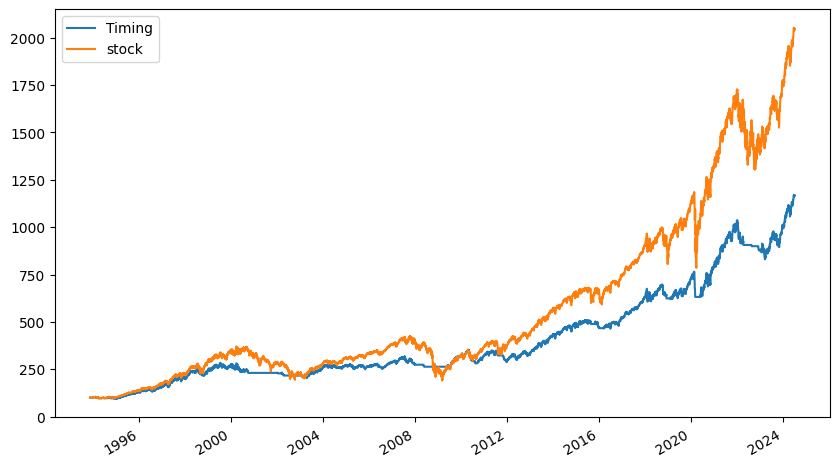

In [23]:
import matplotlib.pyplot as plt

bt_sma_result.prices.iloc[201:, ].rebase().plot(figsize=(10, 6))
plt.show()

추세추종 전략의 경우 이동평균 계산을 위해 처음 200 일간은 투자가 되지 않으므로 매수 후 보유 전략과 시작 시점이 일치하지 않는다. 따라서 200일이 지난 후부터의 데이터를 선택한다. 그 후 `rebase()` 함수를 이용해 데이터의 시작시점을 다시 100으로 만든다.

추세추종 전략을 사용할 경우 2000년 IT 버블이나 2008년 금융위기시 하락폭이 제한된다. 즉 하락추세가 시작되면 주식을 모두 매도하여, 추가적인 하락을 방어한다.

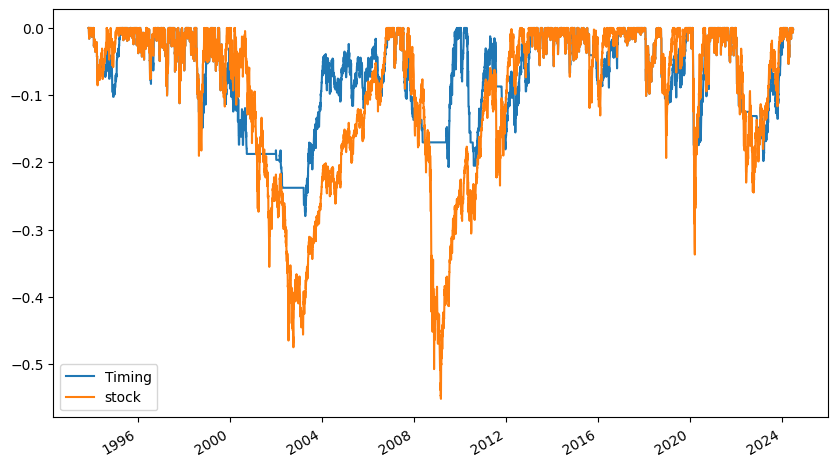

In [24]:
bt_sma_result.prices.iloc[201:, ].rebase().to_drawdown_series().plot(
    figsize=(10, 6))
plt.show()

`to_drawdown_series()` 함수는 낙폭(drawdown)을 계산한다. 앞서 언급한 것 처럼 추세추종 전략을 사용할 경우 하락 방어가 우수하다. 반면 코로나19 사태 직후인 2020년 3월의 경우 추세추종 전략은 추세가 깨져 투자를 하지 않지만, 주식 시장이 급반등 함에 따라 매수 후 보유 전략의 상승분을 따라가지 못하기도 하였다.

In [25]:
bt_sma_result.stats.loc[[
    'total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe', 'daily_sortino'
]]

,Timing,stock
total_return,10.725593,21.092292
cagr,0.081495,0.103519
daily_vol,0.119727,0.186681
max_drawdown,-0.279957,-0.551892
calmar,0.2911,0.187571
daily_sharpe,0.715094,0.621677
daily_sortino,1.086205,0.986337


수익률 자체는 단순 보유전략(stock)이 높지만 변동성이나 MDD와 같은 위험지표는 마켓 타이밍 전략(Timing)이 훨씬 낮다. 결과적으로 위험을 고려한 성과 지표는 마켓 타이밍 전략이 더 우수하다.

### 파라미터 최적화

과연 200일(10개월) 이동평균을 사용하는 것이 최적일까? 혹은 다른 값을 사용했을 때 수익률이 더 좋을수 있지 않을까? 이러한 질문은 트레이더들이 항상 하는 질문이다. '200일'과 같이 우리가 임의로 정하는 변수를 파라미터(parameter)라 하며, 성과가 최대화 되는 파라미터를 찾는 것을 파라미터 최적화라고 한다. 트레이딩에서 이러한 파라미터 최적화는 매우 중요한 작업이다. 앞선 마켓 타이밍 전략에서 이동평균을 계산할 때 사용하는 일수를 변경해가며 수익률을 확인해보도록 하자.

In [26]:
import talib
import bt

data = price[['SPY']].dropna()

def timing(price, n):

    sma = price.apply(lambda x: talib.SMA(x, n))
    stragety = bt.Strategy(n, [
        bt.algos.SelectWhere(price > sma),        
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ])

    backtest = bt.Backtest(stragety, price)

    return (backtest)

n_20 = timing(data, 20)
n_60 = timing(data, 60)
n_100 = timing(data, 100)
n_150 = timing(data, 150)
n_200 = timing(data, 200)
n_250 = timing(data, 250)

result = bt.run(n_20, n_60, n_100, n_150, n_200, n_250)

1. 이동평균을 계산한 후, 백테스트를 생성하는 부분을 `timing()` 함수로 작성한다.
2. 20일부터 250일까지 이동평균을 이용한 마켓타이밍 모델의 백테스트를 생성한다.
3. 모든 백테스트를 한번에 실행한다.

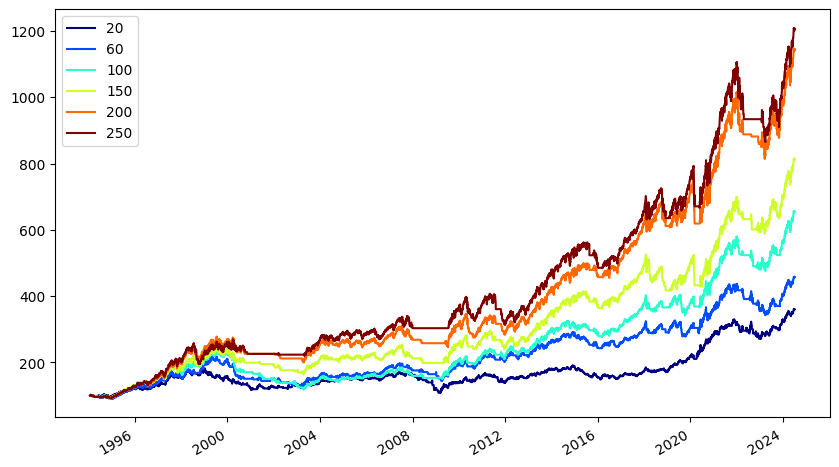

In [27]:
from matplotlib import cm

result.prices[250:].rebase().plot(figsize=(10, 6), colormap=cm.jet)
plt.show()

누적수익률을 확인해보면 단기 보다는 장기 이동평균을 사용할 수록 우수한 성과를 기록한다. 그러나 예를 들어 250일 이동평균이 최고의 수익률을 기록한다고 이것이 최적의 파라미터라고 말하기는 힘들다. 장기 이동평균을 사용하는 것이 단기 이동평균을 사용하는 것보다 성과가 좋은 이유는, 장기 이동평균이 장기적인 추세를 더 잘 반영하기 때문일 수 있다. 그러나 같은 장기 이동평균에서도 250일이 200일 보다 우수한 것은 단순히 우연의 결과일 수 있으며, 백테스트 기간을 다르게 하면 전혀 다른 결과가 나타날 수도 있다.

백테스트 기간에서 최적화된 파라미터가 향후에도 최고의 수익률을 기록할 것이라는 생각은 위험하다. 백테스트에서는 엄청나게 우수한 성과를 보였던 전략을 찾아 용기있게 실제 투자에 나섰다가 과최적화의 저주에 빠져 실망스러운 수익률로 이어지는 경우도 종종 목격한다. 따라서 모델에 사용되는 파라미터의 갯수는 최대한 작게, 그리고 인샘플(in-sample) 뿐만 아니라 아웃오브샘플(out-of-sample) 테스트에서도 뛰어난 성과를 보이는 파라미터를 택하는 것이 좋다.

### 롱숏 전략

지금까지는 주가가 이동평균선 위에 있을 때 매수하며 그렇지 않으면 현금을 보유하는 '롱온리(Long-Only)' 전략에 대한 백테스트를 실시했다. 그러나 추세추종 전략은 상승추세에 대한 베팅뿐만 아니라 공매도, 인버스 ETF 혹은 선물매도 포지션을 통해 하락추세에도 베팅할 수 있다. 

흔히 단기 이동평균선이 중장기 이동평균선을 뚫고 올라가는 골든크로스의 경우 상승추세에 대한 신호를, 반대로 뚫고 내려가는 데드크로스의 경우 하락추세에 대한 신호를 나타낸다. 과연 이러한 신호를 이용해 트레이딩 했을 때 성과가 어떤지 살펴보도록 하자.

In [28]:
import talib

data = price[['SPY']]
SMA_200 = data.apply(lambda x: talib.SMA(x, 200))
SMA_60 = data.apply(lambda x: talib.SMA(x, 60))

먼저 장기추세에 해당하는 200일 지수 이동평균과 단기추세에 해당하는 60일 지수 이동평균을 구한다.

In [29]:
signal = SMA_200.copy()
signal[SMA_60 >= SMA_200] = 1
signal[SMA_60 < SMA_200] = -1
signal[signal.isnull()] = 0

만일 60일 이동평균이 200일 이동평균보다 위에 있을 경우(골든크로스) 100% 투자 즉 매수를 하며, 반대의 경우(데드크로스) -100% 투자 즉 매도를 한다. 이동평균을 계산하기 위한 처음 200일 부분은 데이터가 없으므로 포지션을 0으로 둔다.

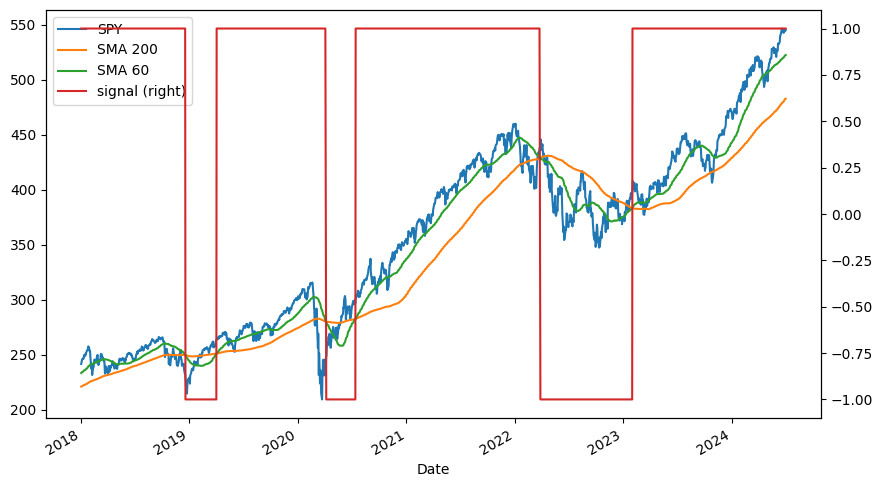

In [30]:
import matplotlib.pyplot as plt

bind = pd.concat([data, SMA_200, SMA_60, signal], axis=1)
bind.columns = ['SPY', 'SMA 200', 'SMA 60', 'signal']
bind.loc['2018':].plot(figsize=(10, 6), secondary_y=['signal'])
plt.show()

2018년 이후부터 주가와 각 이동평균선, 신호를 그림으로 나타내보면 단기 이동평균선(SMA 60)이 장기 이동평균선(SMA 200) 위에 있을 경우에는 매수(1), 그렇지 않을 때는 매도(-1)를 하는 것이 확인된다. 이제 해당 전략의 백테스트를 실행해보자.

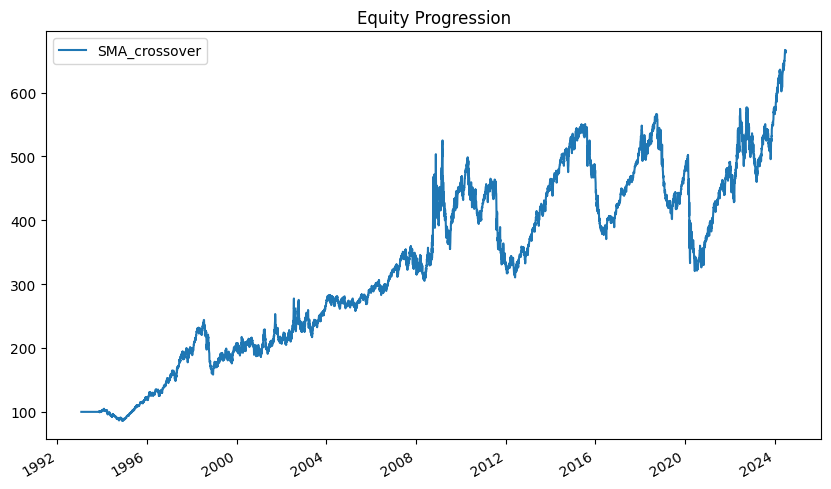

In [31]:
import bt

strategy = bt.Strategy(
    'SMA_crossover',
    [bt.algos.SelectAll(),
     bt.algos.WeighTarget(signal),
     bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

`bt.algos.WeighTarget()` 함수 내에 각 시점별 비중을 입력하면, 해당 시점과 비중에 맞춰 리밸런싱이 실시된다. 이를 통해 해당 패키지에서 함수 형태로 제공하지 않는 매우 복잡한 전략의 백테스트도 시기별 비중을 직접 계산해 얼마든지 실행할 수 있다.

결과를 살펴보면 장기간 동안 우상향을 하지만 2011년, 2015~16년, 2020년 등에는 엄청난 낙폭을 기록하기도 했다. 월별 및 연도별 수익률을 확인해보자.

In [32]:
result.display_monthly_returns()

  Year     Jan    Feb     Mar    Apr    May    Jun    Jul     Aug    Sep     Oct    Nov    Dec     YTD
------  ------  -----  ------  -----  -----  -----  -----  ------  -----  ------  -----  -----  ------
  1993    0      0       0      0      0      0      0       0      0       0     -0.07   1.23    1.16
  1994    3.49  -2.92   -4.19   1.12  -4.8    2.21  -3.16   -3.73  -1.04    2.84  -3.98   0.73  -13.08
  1995    3.36   4.08    2.78   2.96   3.97   2.02   3.22    0.45   4.24   -0.29   4.45   1.57   38.05
  1996    3.56   0.32    1.72   1.09   2.27   0.88  -4.49    1.93   5.59    3.23   7.3   -2.38   22.5
  1997    6.18   0.96   -4.41   6.26   6.32   4.11   7.93   -5.18   4.81   -2.45   3.87   1.91   33.47
  1998    1.29   6.93    4.88   1.28  -2.08   4.26  -1.35  -14.12   6.36  -17.03  -5.51   4.58  -13.23
  1999    3.52  -3.21    4.15   3.8   -2.29   5.54  -3.1    -0.52  -2.23    6.41   1.67   5.71   20.39
  2000   -4.98  -1.52    9.69  -3.51  -1.57   1.97  -1.57    6.53  -5.49  

 `display_monthly_returns()` 메서드를 통해 월단위 및 연단위 수익률을 확인할 수 있다. 2020년에는 코로나 이후 주가가 급등했음에도 불구하고, 롱숏 전략은 -20.55%의 큰 손실을 기록하였다. 왜 이런 결과가 나왔는지 해당 구간을 자세히 살펴보도록 하자.

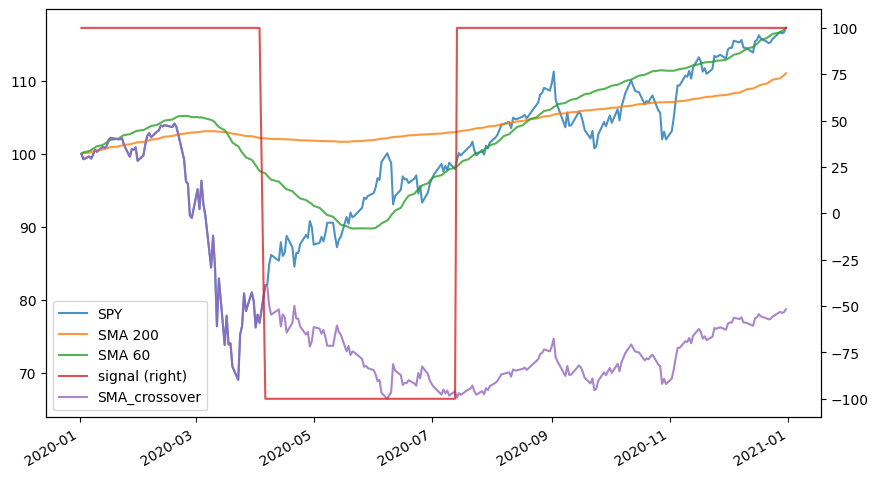

In [33]:
pd.concat([bind, result.prices],
          axis=1).loc['2020'].rebase().plot(figsize=(10, 6),
                                            secondary_y=['signal'],
                                            alpha=0.8)
plt.show()

코로나 사태로 인해 2020년 3월부터 미국 주식(SPY)은 급격하게 하락하기 시작했으며, 3월 중순에는 60일 이동평균선이 200일 이동평균선을 하회함에 따라 숏 신호가 발생하였다. 그러나 공교롭게도 해당 시점부터 시장은 바닥을 다지고 엄청난 상승을 보였으며, 전략(SMA_crossover)에서는 숏 포지션을 취하고 있는 만큼 손실이 발생하기 시작한다. 6월이 되서야 다시 골든크로스가 발생하여 롱 포지션으로 전환하였지만, 불과 3달동안 복구할 수 없을 정도의 손실을 입게 되었다. 실제로 추세추종 전략을 사용하는 많은 펀드들이 2020년 3월부터 6월까지 막대한 손실을 입었다. 2020년 1~3월에는 롱 포지션에서 손실을 입고, 3월부터는 숏 포지션에서 손실을 입어 양방향에서 모두 손실을 입은 것이다.

만일 롱온리 전략을 택했다면 3월부터 6월까지 단순히 수익을 얻지 못한것에 그쳤겠지만, 숏 포지션으로 인해 손실이 배가 된 것이다. 이처럼 숏 베팅은 하락 시장에서도 돈을 벌 수 있게 해주지만, 예상치 못한 급반등이 나올 경우 손실을 입히는 양날의 검이 되기도 한다. 이를 방지하기 위해 트레이딩에서는 다양한 신호의 결합, 손실제한(스탑로스, 로스컷) 등을 추가하기도 한다.

## 평균회귀 전략 백테스트

추세추종 전략은 주가가 동일한 방향으로 지속된다고 보는 반면, 평균회귀 전략은 주가가 평균으로 회귀한다고 보며 이에 베팅한다. 주가가 무한정 한방향으로 지속될 수는 없기에 추세추종 전략과 평균회귀 전략을 잘 조합할 필요가 있다.

### RSI를 이용한 전략

RSI는 일정기간 동안 주가의 상승폭과 하락폭의 크기를 비교해 상승과 하락의 상대적인 강도를 나타낸 지표로써, 일반적으로 RSI가 70 이상일 경우 과매수 구간으로써 매도할 때를, 30 이하일 경우 과매도 구간으로써 매수해야 할 때로 여겨진다. 이에 대한 백테스트를 실행해보도록 하자.

In [34]:
import talib

data = price[['SPY']]
spy_rsi = data.apply(lambda x: talib.RSI(x, 14))

signal = spy_rsi.copy()
signal[spy_rsi > 70] = -1
signal[spy_rsi < 30] = 1
signal[(spy_rsi <= 70) & (spy_rsi >= 30)] = 0
signal[signal.isnull()] = 0

먼저 `apply()` 함수 내부에 `RSI()`을 이용해 14일 기준 RSI를 구한다. 그 후 RSI가 70을 초과하면 -1(숏 포지션), 30 미만이면 1(롱 포지션), 30과 70 사이면 0(뉴트럴)인 신호를 만든다.

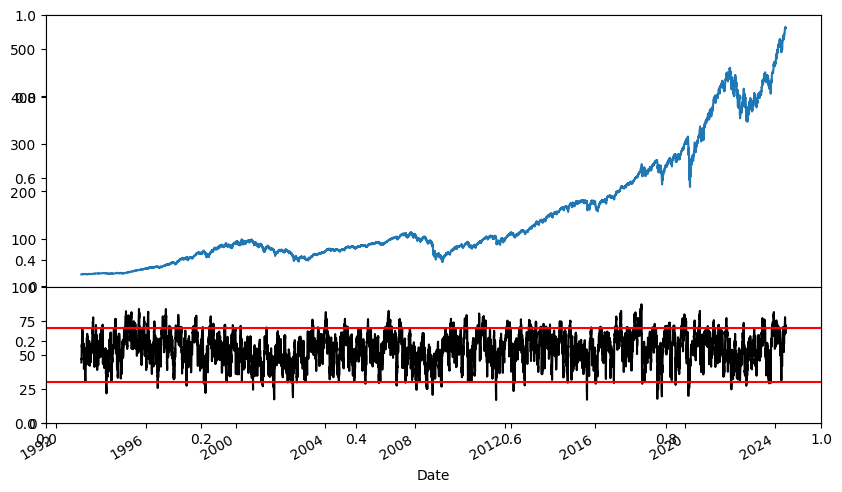

In [35]:
from matplotlib import gridspec

fig = plt.subplots(figsize=(10, 6), sharex=True)
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax1 = data['SPY'].plot()
ax1.set_xlabel('')
ax1.axes.xaxis.set_ticks([])

ax2 = plt.subplot(gs[1])
ax2 = spy_rsi['SPY'].plot(color='black', ylim=[0, 100])
ax2 = plt.axhline(y=30, color='red', linestyle='-')
ax2 = plt.axhline(y=70, color='red', linestyle='-')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

위쪽의 그래프는 주가를 나타내며, 아래쪽의 그래프는 RSI를 나타낸다. 이제 만들어진 신호를 바탕으로 백테스트를 실행해보자.

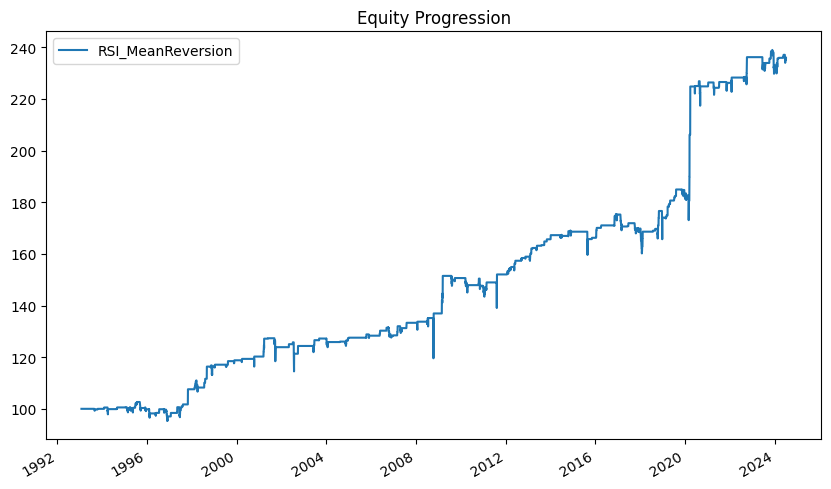

In [36]:
strategy = bt.Strategy('RSI_MeanReversion',
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

RSI를 이용하여 트레이딩을 할 경우 장기간으로 큰 손실없이 잘 작동하지만, 과매수 혹은 과매도로 인한 투자 신호가 나타나는 경우가 드물어 누적수익률 자체도 그렇게 높지 않다. 반면 2020년의 경우 추세추종 전략과는 반대로 3월 급락장에서 과매도 신호로 인해 매수를 함으로써, 반등으로 인해 상당한 수익을 거두기도 한다. 이처럼 추세추종과 평균회귀는 서로 상반되는 특징이 있으므로, 이를 잘 조합하면 훨씬 안정적인 수익을 거둘 수 있는 트레이딩 전략을 개발할 수도 있다.

성과 중 주요 지표를 확인해보도록 하자.

In [37]:
result.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,RSI_MeanReversion
total_return,1.359507
cagr,0.027696
daily_vol,0.062595
max_drawdown,-0.115262
calmar,0.240292
daily_sharpe,0.467396


### 볼린저 밴드를 이용한 전략

이번에는 볼린저 밴드를 이용한 평균회귀 전략을 백테스트 해보도록 하겠다. 볼린저밴드는 이동평균선을 중심으로 일정 표준편차를 상한선과 하한선으로 설정한 밴드다. 주가가 정규분포를 따른다면 주가의 움직임은 상한선과 하한선으로 구성된 밴드 내에서만 움직일 확률이 높다. 따라서 주가가 상한선 위에 있다는 것은 과매수 상태이므로 하락할 가능성이 높으르로 숏 포지션을, 하단선 아래에 있다는 것은 과매도 상태이므로 상승할 가능성이 높으므로 롱 포지션을 취한다.

In [38]:
upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data['SPY'],
                                             nbdevup=2,
                                             nbdevdn=2,
                                             timeperiod=20)

bb = pd.concat([upper_2sd, mid_2sd, lower_2sd, data['SPY']], axis=1)
bb.columns = ['Upper Band', 'Mid Band', 'Lower Band', 'SPY']

`BBANDS()` 함수를 이용해 20일 기준 2 표준편차에 해당하는 볼린저 밴드의 상, 중, 하단 값을 계산한 후 하나의 데이터프레임으로 묶어준다.

In [39]:
import numpy as np

signal = data.copy()
signal['SPY'] = np.nan

signal[bb['SPY'] > bb['Upper Band']] = -1
signal[bb['SPY'] < bb['Lower Band']] = 1
signal[signal.isnull()] = 0

주가가 상한선 위에 있을 경우 -1(숏 포지션), 주가가 하한선 아래에 있을 경우 1(롱 포지션), 그 외의 경우 0(뉴트럴)의 신호를 만둔다. 해당 신호를 바탕으로 백테스트를 실행해보자.

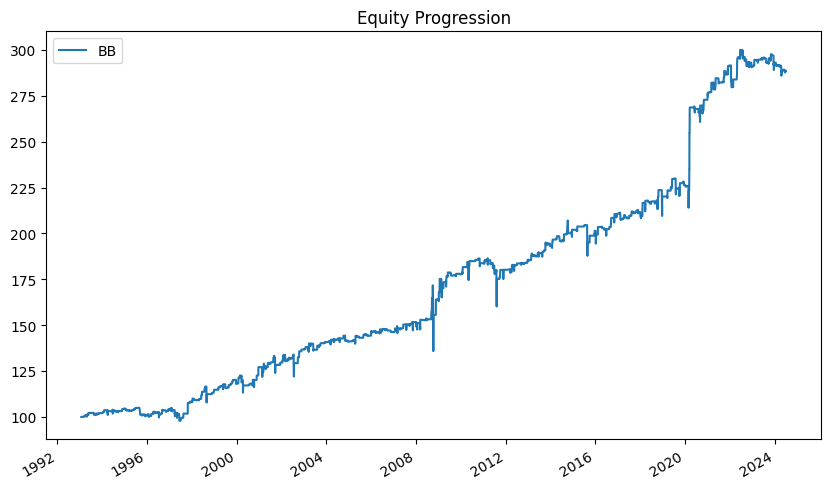

In [40]:
strategy = bt.Strategy('BB',
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

RSI와 마찬가지로 볼린저밴드를 이용한 평균회귀 트레이딩을 할 경우에도 장기간으로 큰 손실없이 잘 작동한다. 주요 성과 지표는 다음과 같다.

In [41]:
result.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,BB
total_return,1.88455
cagr,0.034289
daily_vol,0.073518
max_drawdown,-0.208759
calmar,0.16425
daily_sharpe,0.495299


## bt 패키지의 함수 

마지막으로 bt 패키지의 함수들을 정리해보도록 하겠다.

- 유니버스 선택
    - `bt.algos.SelectAll()`: 모든 종목 선택
    - `bt.algos.SelectHasData()`: 일정 갯수 이상의 데이터가 있는 종목 선택
    - `bt.algos.SelectMomentum()`: 모멘텀 상위 종목 선택, `bt.algos.SelectAll()`을 먼저 불러와야 함
    - `bt.algos.SelectWhere()`: 입력값이 True 일때만 투자

- 비중 선택
    - `bt.algos.WeighEqually()`: 동일 비중
    - `bt.algos.WeighSpecified()`: 비중 직접 입력. 리밸런싱 마다 동일한 값 적용.
    - `bt.algos.WeighTarget(signal)`: 비중 직접 입력. 리밸런싱 마다 입력한 값 적용.
    - `bt.algos.WeighERC()`: 위험균형 전략
    - `bt.algos.WeighInvVol()`: 역변동성 전략
    - `bt.algos.WeighMeanVar()`: 최대샤프지수 전략

- 리밸런싱 시점
    - `bt.algos.RunOnce()`: 처음 한번만 리밸런싱
    - `bt.algos.RunDaily()`: 매일 리밸런싱
    - `bt.algos.RunMonthly()`: 매월 리밸런싱
    - `bt.algos.RunQuarterly()`: 매분기 리밸런싱
    - `bt.algos.RunWeekly()`: 매주 리밸런싱
    - `bt.algos.RunYearly()`: 매년 리밸런싱

- 리밸런싱 방법
    - `bt.algos.Rebalance()`: 선택한 시점과 비중에 따라 리밸런싱
    - `bt.algos.RebalanceOverTime()`: n일에 걸쳐 리밸런싱

- 기타 함수들
    - `plot_weights()`: 투자 비중 출력
    - `get_security_weights()`: 투자 비중을 데이터프레임 형태로 반환
    - `prices()`: 누적수익률을 데이터프레임 형태로 구하기
    - `prices.rebase()`: 특정 시점부터 다시 100으로 환산
    - `prices.to_returns()`: 수익률 계산
    - `display()`: 성과 측정치
    - `display_monthly_returns()`: 월간 수익률 구하기
    - `turnover()`: 회전율 구하기

```{note}
위에서 백테스트한 추세추종과 평균회귀 전략의 경우 신호가 발생하면 해당일 종가에 포지션을 취한다고 가정했다. 그러나 현실에서는 종가 직전까지 발생한 신호를 바탕으로 종가에 매매를 하거나 종가로 계산된 신호를 바탕으로 다음날 시가에 매매를 해야하므로, 백테스트의 수익률과 실제 수익률은 상당히 차이가 있을 수 있다. 또한 매매수수료와 시장충격으로 인해 백테스트의 수익률과 실제 수익률간 차이가 발생할 수도 있다.
```

```{note}
크롤링으로 수집한 데이터로 개별 주식에 대한 백테스트를 하기에는 생존 편향, 소급 편향 등의 문제가 있으며, 난이도 역시 매우 높다. 두물머리에서 제공하는 '올라떼' 사이트에서는 전 세계 주식을 대상으로 양질의 데이터를 통한 각종 팩터 모형에 대한 백테스트를 클릭만으로 수행할 수 있으니 이를 참조하기 바란다.

https://allatte.com/
```